
**machine learning. Serve: Avia Golan**


I received data on 12 types of cells, some of which are violent and some non-violent. Each cell has specific characteristics, which are the expression levels of proteins. Based on these characteristics, I aimed to classify whether the cells are violent or non-violent. For this classification task, I used four different models.

are imported into the appropriate libraries

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import  cross_val_score, cross_val_predict, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, make_scorer, classification_report, confusion_matrix
import numpy as np
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif,f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


Opening the drive and the file

In [ ]:
drive.mount('/content/drive')
file_path= '/content/drive/MyDrive/projectW/Machine_learning/MQ-analysis-Ori-20220720.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Sorting and cleaning the data

In [ ]:
df = pd.read_excel(file_path)#,encoding='ISO-8859-1')
columns_to_drop = [column for column in df.columns if column.startswith('iBAQ')] #Deletes from the data the quantitative data that are not relevant to us.
# Drop these columns
df.drop(columns=columns_to_drop, inplace=True)
df=df.transpose() #Transforming the data - properties (proteins) into the columns and rows of the examples
df = df.drop(['Protein IDs', 'Gene names', 'Fasta headers', 'Mol. weight [kDa]','Peptide sequences','Phospho (STY) site IDs','Phospho (STY) site positions']) #Deleting irrelevant identification columns - we left the protein name as an identification column
df = df.dropna(axis='columns', how='any') #If there is no name for the protein, it is probably not important enough, so delete it
#Using an index in the beginning and end rows of rows related to the number of peptides in each cell. Below the threshold of 2 peptides we removed the corresponding protein column.
start_row = 'Razor + unique peptides HU-1 1'
end_row = 'Razor + unique peptides T-63 3'

# Identify the index positions of the start and end rows
start_index = df.index.get_loc(start_row)
end_index = df.index.get_loc(end_row)

# Iterate over each column and check for the presence of 0 or 1 within the specified range of rows
columns_to_drop = []
for column in df.columns:
    if (df.iloc[start_index:end_index+1][column].isin([0, 1])).any():
        columns_to_drop.append(column)

# Drop the identified columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)

# Slice the DataFrame to include rows from the start_row to the end and drop columns
df= df.iloc[:start_index]
df=df.T
name_rows=df.iloc[:,0].tolist() #take the first coulmn and change it to list
df=df.iloc[:,1:14]           #take the next coulmns
df.index=name_rows             #change the name of rows
df=df.transpose()
#Adding a classification column according to a violent or non-violent cell - when we did not insert the classification column into the data
#itself because afterwards the classification column and the other data columns need to be separated.
#Balanced distribution of the classification column - where cells of T-25 and cells of HU-1 are defined as 0 (less violent) while cells of Rev-2-T-6 and cells of T-63 are defined as 1 (violent).
Y=df.index
replacement_dict = {item: 0 if ('T-25' in item or 'HU-1' in item) else 1 for item in Y}
# Use the dictionary to replace elements in the list
Y = [replacement_dict[item] for item in Y]
X = df
#Checking whether there are missing values in the data and if so, remove the property row with the missing value(s)
missing_values = X.isna().any()
if missing_values.any():
    print("Columns with missing values:")
    X = X.dropna(how='any')
else:
    print("No missing values found in the data.")

No missing values found in the data.


Correlation test to see if there is a correlation between the

1.   List item
2.   List item

characteristics (proteins) in order to make feature selection accordingly

In [ ]:
df.corr()   #Checking whether there is a correlation between the characteristics in the data

,Histone H2A type 1-H;Histone H2A.J;Histone H2A type 1-K;Histone H2A type 1-F;Histone H2A type 3;Histone H2A,Histone H4,Histone H3.3C;Histone H3.3;Histone H3,Histone H2B;Histone H2B type 1-P;Histone H2B type 1-K;Histone H2B type 1-B;Histone H2B type 1-F/J/L;Histone H2B type 1-A,Glyceraldehyde-3-phosphate dehydrogenase,"Peptidyl-prolyl cis-trans isomerase A;Peptidyl-prolyl cis-trans isomerase A, N-terminally processed","Actin, cytoplasmic 2;Actin, cytoplasmic 2, N-terminally processed","Fatty acid-binding protein, epidermal",Elongation factor 1-alpha 1,Tubulin alpha-1B chain,...,Kinesin-like protein;Kinesin-like protein KIF21B,Transcription initiation factor TFIID subunit 1,CREB-binding protein;Histone acetyltransferase p300,A-kinase anchor protein 9,Little elongation complex subunit 1,Protein MON2 homolog,Retinoic acid-induced protein 1,Pericentrin,Histone-lysine N-methyltransferase SETD2,GRIP and coiled-coil domain-containing protein 2
Histone H2A type 1-H;Histone H2A.J;Histone H2A type 1-K;Histone H2A type 1-F;Histone H2A type 3;Histone H2A,1.000000,0.567922,0.808155,0.488152,-0.269631,0.405853,-0.440771,0.493872,-0.710313,-0.388417,...,-0.429549,-0.173906,0.414292,0.005706,0.373576,-0.507691,-0.158348,0.047457,0.225241,-0.147592
Histone H4,0.567922,1.000000,0.269807,0.825036,-0.272074,0.018451,-0.494959,0.554834,-0.383439,-0.113622,...,-0.578549,-0.619770,0.367755,-0.290277,0.355143,-0.104587,-0.627454,-0.275434,-0.002583,-0.446612
Histone H3.3C;Histone H3.3;Histone H3,0.808155,0.269807,1.000000,0.365072,0.153395,0.724184,0.064550,0.424157,-0.703867,-0.241703,...,-0.043502,0.273327,0.400729,0.558736,0.526386,-0.577000,0.321656,0.050822,0.521094,0.342998
Histone H2B;Histone H2B type 1-P;Histone H2B type 1-K;Histone H2B type 1-B;Histone H2B type 1-F/J/L;Histone H2B type 1-A,0.488152,0.825036,0.365072,1.000000,-0.100476,0.366935,-0.211698,0.895803,-0.704108,0.175975,...,-0.699199,-0.623068,0.553809,-0.045841,0.600506,-0.190255,-0.342210,-0.189595,0.103136,-0.201252
Glyceraldehyde-3-phosphate dehydrogenase,-0.269631,-0.272074,0.153395,-0.100476,1.000000,0.092843,0.788462,-0.011055,-0.002921,0.685687,...,0.656813,0.596200,-0.381322,0.663365,-0.016907,0.108403,0.272706,-0.580422,0.304411,0.438276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Protein MON2 homolog,-0.507691,-0.104587,-0.577000,-0.190255,0.108403,-0.669071,-0.207739,-0.218081,0.443679,0.371325,...,0.227868,-0.210345,-0.354555,-0.435886,-0.515235,1.000000,-0.291596,-0.410036,-0.784447,-0.453139
Retinoic acid-induced protein 1,-0.158348,-0.627454,0.321656,-0.342210,0.272706,0.630527,0.624146,-0.175398,-0.035951,-0.097138,...,0.368367,0.698204,-0.065602,0.721263,0.136595,-0.291596,1.000000,0.404634,0.436118,0.733550
Pericentrin,0.047457,-0.275434,0.050822,-0.189595,-0.580422,0.391883,-0.117206,-0.114414,0.020564,-0.605915,...,-0.305684,-0.012629,0.245083,-0.006413,0.286041,-0.410036,0.404634,1.000000,0.290131,0.357327
Histone-lysine N-methyltransferase SETD2,0.225241,-0.002583,0.521094,0.103136,0.304411,0.707564,0.521187,0.084299,-0.252784,-0.163463,...,0.142374,0.495549,0.181961,0.700203,0.585912,-0.784447,0.436118,0.290131,1.000000,0.726884


***

Due to the high correlation between the features, I filtered out the less important variables using feature importance metrics. This helps avoid issues like overfitting, especially when there are similar variables, and improves the model's performance and efficiency.

In [ ]:
# Fit the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, Y)

# Compute the feature importance scores
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# Select the top 20 features with the highest importance scores
top_features = feature_importances.nlargest(20).index
X = X[top_features]  # Keep only the top 20 features in the dataset


**First model: decision tree, visual**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Cross-validated Metrics:
Accuracy: 0.8333333333333333
Precision: 0.625
Recall: 0.75
Roc_auc: 0.8125

classification report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.83      0.83      0.83         6

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12


confusion matrix:
[[5 1]
 [1 5]]
                                              Feature  Importance
1                           Calcyclin-binding protein         1.0
0   Histone H2B;Histone H2B type 1-P;Histone H2B t...         0.0
18             Polypyrimidine tract-binding protein 1         0.0
17                       Superoxide dismutase [Cu-Zn]         0.0
16              Chromatin assembly factor 1 subunit B         0.0
15              Fatty acid-binding protein, epidermal         0.0
14              ATP synthase subunit O, mitochondria

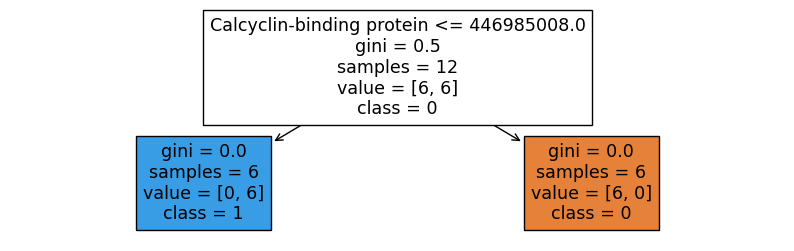

In [ ]:
#First model - a decision tree that visually describes the division and classification.
decision_tree = DecisionTreeClassifier(random_state=42)# Initialize the decision tree classifier
# Train the decision tree classifier on the entire dataset
decision_tree.fit(X, Y)
# Perform cross-validation
#cv_scores = cross_val_score(decision_tree, X, Y, cv=4)
scoring = ['accuracy', 'precision', 'recall','roc_auc']
cv_results = cross_validate(decision_tree, X, Y, scoring=scoring, cv=4, return_train_score=False)

#Consider the prediction of the model
y_pred = cross_val_predict(decision_tree, X, Y, cv=4)

# Print metrics
print("\nCross-validated Metrics:")
for metric in scoring:
    print(f"{metric.capitalize()}: {cv_results['test_' + metric].mean()}")
#print("Cross validation scores: " ,cv_scores) #Print the accuracy score for each fold of cross validation for the model
#print("Mean CV scores: " , np.mean(cv_scores)) #Print the average accuracy score for cross validation of the model
print("\nclassification report:")
print(classification_report(Y,y_pred))#Printing the classification report to give us a concise summary of the model's performance using various metrics.
print("\nconfusion matrix:")
print(confusion_matrix(Y,y_pred))#Printing the confusion matrix to provide us with a detailed breakdown of the model predictions


# Print feature importance
feature_importances = decision_tree.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns,
                                      'Importance': feature_importances}) #Printing the feature importance of the model inside a data frame

# Sort the DataFrame by Importance in descending order to get the ranking
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 10 features with the greatest importance
top_10_features = feature_importance_df.head(10)
print(top_10_features)
#Drawing the resulting tree model
plt.figure(figsize=(10, 3))
plot_tree(decision_tree, filled=True, feature_names=X.columns, class_names=['0', '1'])
plt.show()

The results indicate that the decision tree model performs well with an accuracy of 83.33%. The results also show equal performance between the two categories (violent and non-violent), with a Precision and Recall of 0.83 for both categories.

The metrics indicate that the model performs well in classifying the categories, but the Precision is relatively lower for category 1 (violent), suggesting minor misclassifications of violent cells.

The metrics are based on accuracy, positive prediction (Precision), overall detection (Recall), and discrimination ability (ROC AUC).

Regarding feature importance, the model found that "Calcyclin-binding protein" is the most important feature with an importance score of 1, while the other features had an importance score of zero.






*****

**Second model: Random Forest** - a more sophisticated model for a decision tree model. The features important can be extracted according to his calculation.

In [ ]:
#random forest
random = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5, min_samples_split=4)#Initialize the model
random.fit(X, Y)#Training the model
# Perform cross-validation
#cv_scores = cross_val_score(random, X, Y, cv=4)
scoring = ['accuracy', 'precision', 'recall','roc_auc']
cv_results = cross_validate(random, X, Y, scoring=scoring, cv=4, return_train_score=False)
y_pred = cross_val_predict(random, X, Y, cv=4) #Consider the prediction of the model

# Print metrics
print("\nCross-validated Metrics:")
for metric in scoring:
    print(f"{metric.capitalize()}: {cv_results['test_' + metric].mean()}")
#print("Cross validation scores: " ,cv_scores) #Print the accuracy score for each fold of cross validation for the model
#print("Mean CV scores: " , np.mean(cv_scores)) #Print the average accuracy score for cross validation of the model
print("\nclassification report:")
print(classification_report(Y,y_pred))#Printing the classification report to give us a concise summary of the model's performance using various metrics.
print("\nconfusion matrix:")
print(confusion_matrix(Y,y_pred))#Printing the confusion matrix to provide us with a detailed breakdown of the model predictions



# Get feature importances
feature_importances = random.feature_importances_

# Create a DataFrame to store the feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns,
                                      'Importance': feature_importances})

# Sort the DataFrame by Importance in descending order to get the ranking
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 10 features with the greatest importance
top_10_features = feature_importance_df.head(10)
print("The 10 feature importance:")
print(top_10_features)


Cross-validated Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Roc_auc: 1.0

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12


confusion matrix:
[[6 0]
 [0 6]]
The 10 feature importance:
                                              Feature  Importance
15              Fatty acid-binding protein, epidermal        0.08
1                           Calcyclin-binding protein        0.08
9            28S ribosomal protein S34, mitochondrial        0.07
14              ATP synthase subunit O, mitochondrial        0.07
5                           Cyclin-dependent kinase 1        0.07
6                                Cytochrome b5 type B        0.07
0   Histone H2B;Histone H2B type 1-P;Histone H

The Random Forest model performed flawlessly, achieving perfect scores across all metrics—accuracy, precision, recall, and ROC AUC of 1.0—indicating no misclassifications (confusion matrix: [[6, 0], [0, 6]]). The classification report further confirms this with a perfect F1-score of 1.0 for both classes. The top 10 features driving the model's decisions include "Fatty acid-binding protein, epidermal" and "Calcyclin-binding protein," both with an importance score of 0.08.

While these results are impressive, the absence of additional data for testing raises concerns about potential overfitting. The model may have become too tailored to the training data, leading to overly optimistic results. To mitigate this risk, further validation, such as using cross-validation on new data or incorporating additional metrics like AUC, should be conducted.

*****

**Third model: logistic regression with L2 regularization** - it is possible to extract the features important according to its calculation (the characteristics with the absolute coefficients with the highest value). Used when the dependent variable is categorical (as we have in Data - violent (1) or less violent(0)).

In [ ]:
#A second model is also visual - by getting the coefficients of each characteristic (protein) and thus it shows its level of
#importance - where a high coefficient represents a high level of importance for the protein compared to a lower coefficient.
logreg_l2 = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', multi_class='ovr')
scaler = StandardScaler()  #This is a linear model, so we made a scalling characteristic of a linear model
X_sd = scaler.fit_transform(X)
logreg_l2.fit(X_sd, Y) #Training the model
#cv_scores=cross_val_score(logreg_l2,X_sd,Y,cv=4)
scoring = ['accuracy', 'precision', 'recall','roc_auc']
cv_results = cross_validate(logreg_l2, X_sd, Y, scoring=scoring, cv=4, return_train_score=False)
y_pred = cross_val_predict(logreg_l2, X_sd, Y, cv=4) #Consider the prediction of the model

# Print metrics
print("\nCross-validated Metrics:")
for metric in scoring:
    print(f"{metric.capitalize()}: {cv_results['test_' + metric].mean()}")
#print("Cross validation scores: " ,cv_scores) #Print the accuracy score for each fold of cross validation for the model
#print("Mean CV scores: " , np.mean(cv_scores)) #Print the average accuracy score for cross validation of the model
print("\nclassification report:")
print(classification_report(Y,y_pred))#Printing the classification report to give us a concise summary of the model's performance using various metrics.
print("\nconfusion matrix:")
print(confusion_matrix(Y,y_pred))#Printing the confusion matrix to provide us with a detailed breakdown of the model predictions

feature_names = X.columns #Inserting the names of the proteins into a variable
coefficients = logreg_l2.coef_[0] #The model coefficients (b0....bn)
print("Coefficients of the Logistic regression with L2 regularization model:")
print(coefficients)
coef_feature_pairs = [(abs(coef), feature_name) for coef, feature_name in zip(coefficients, feature_names)] #Matching coefficient to characteristic (protein)

# Sort the list of tuples based on the absolute values of coefficients in descending order
coef_feature_pairs.sort(reverse=True)

# Print the top 10 coefficients with their corresponding feature names
print("Top 10 Coefficients:")
for i, (coef, feature_name) in enumerate(coef_feature_pairs[:10], start=1):
    print(f"{i}. {feature_name}: {coef}")

feature_importance = np.abs(coefficients)

# Get the indices of the top 10 feature importance values
top_indices = np.argsort(feature_importance)[::-1][:10]

# Print the top 10 feature importance values along with their corresponding feature names
print("\nTop 10 feature importance values according to the L2 logistic regression model:")
for i, index in enumerate(top_indices, start=1):
    print(f"{feature_names[index]}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre


Cross-validated Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Roc_auc: 1.0

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12


confusion matrix:
[[6 0]
 [0 6]]
Coefficients of the Logistic regression with L2 regularization model:
[-0.30291768 -0.19494547 -0.19347677 -0.312817    0.2057535  -0.28667889
  0.12733092 -0.32261639 -0.13490061  0.16460232 -0.29057231 -0.22502716
 -0.33452409 -0.16071657  0.18242217 -0.27323795 -0.4258901  -0.22398713
 -0.18262866  0.12004032]
Top 10 Coefficients:
1. Chromatin assembly factor 1 subunit B: 0.4258901019143619
2. Structural maintenance of chromosomes protein 2: 0.33452409154078205
3. Trifunctional purine biosynthetic protein adenosine-3;Phosphori

The Logistic Regression model with L2 regularization showed perfect performance with accuracy, precision, recall, and ROC AUC all at 1.0, indicating correct classification of all instances with no errors (confusion matrix: [[6, 0], [0, 6]]). The classification report confirms flawless performance with an F1-Score of 1.0 for both classes.

The most important features in the model's decision-making include "Chromatin assembly factor 1 subunit B" and "Structural maintenance of chromosomes protein 2," both with very high importance.

****


**Fourth model: SVM** - I made a review according to which type of kernel to use in order to adapt the model to the data as well as pre-processing of the data (standardization) as is characteristic of a linear based model (as in our case). It is a kind of classification - separates 2 groups (as in our case between a group of violent cells (1) and a group of less violent cells (0)). In addition, it is more challenging to extract from it the importance of the features according to its calculation, but we will be based on the coefficients of the model as is characteristic of a linear based model (as in our case - according to the absolute value of the coefficients of the feature, when the coefficient is larger, the characteristic is more important)

In [ ]:
#An initial check on what kind of kernel to use for data. In order to study the data and see what is most suitable.
#It is evident that the most suitable is a linear kernel
def evaluate_svm_kernel(X, Y, kernel_type):
    svm_model = SVC(kernel=kernel_type, C=0.1, random_state=42) #Initialize the model
    svm_model.fit(X, Y)#Training the model
    y_pred = cross_val_predict(svm_model, X, Y, cv=4) #Consider the prediction of the model
    # Perform cross-validation
    cv_scores = cross_val_score(svm_model, X, Y, cv=4, scoring='accuracy')
    print(f"Kernel: {kernel_type}")
    print("Cross validation scores: " ,cv_scores) #Print the accuracy score for each fold of cross validation for the model
    print("Mean CV scores: " , np.mean(cv_scores)) #Print the average accuracy score for cross validation of the model
    print("\nclassification report:")
    print(classification_report(Y,y_pred))#Printing the classification report to give us a concise summary of the model's performance using various metrics.
    print("\nconfusion matrix:")
    print(confusion_matrix(Y,y_pred))#Printing the confusion matrix to provide us with a detailed breakdown of the model predictions

# Evaluate for different kernels
scaler = StandardScaler() #This is a linear model, so we made a scalling characteristic of a linear model
X_sd = scaler.fit_transform(X)
kernels = ['linear', 'poly', 'rbf']
for kernel in kernels:
    evaluate_svm_kernel(X_sd, Y, kernel)

Kernel: linear
Cross validation scores:  [1. 1. 1. 1.]
Mean CV scores:  1.0

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12


confusion matrix:
[[6 0]
 [0 6]]
Kernel: poly
Cross validation scores:  [1.         0.66666667 0.66666667 1.        ]
Mean CV scores:  0.8333333333333333

classification report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.83      0.83      0.83         6

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12


confusion matrix:
[[5 1]
 [1 5]]
Kernel: rbf
Cross validation scor

The SVM results show varying performance depending on the kernel type:

Linear Kernel: The model performed perfectly with accuracy, precision, recall, and F1-Score of 1.0 for all categories. The confusion matrix shows no errors ([[6, 0], [0, 6]]), and the performance was perfect across all 12 samples.

Polynomial Kernel: The model showed good performance with an accuracy and F1-Score of 0.83, but there were some errors in predictions (confusion matrix: [[5, 1], [1, 5]]). The mean score was 0.83.

RBF Kernel: The model performed poorly with an accuracy and F1-Score of 0.33, indicating almost random predictions (confusion matrix: [[2, 4], [4, 2]]).

*****

In [ ]:
#SVM
svm_model = SVC(kernel='linear', C=0.1, random_state=42)#Initialize the model
scaler = StandardScaler() #This is a linear model, so we made a scalling characteristic of a linear model
X_sd = scaler.fit_transform(X)
svm_model.fit(X_sd, Y)#Training the model
#svm_cv_scores = cross_val_score(svm_model, X_sd, Y, cv=4)   # Perform cross-validation
scoring = ['accuracy', 'precision', 'recall','roc_auc']
cv_results = cross_validate(svm_model, X_sd, Y, scoring=scoring, cv=4, return_train_score=False)
y_pred = cross_val_predict(svm_model, X_sd, Y, cv=4) #Consider the prediction of the model

# Print metrics
print("\nCross-validated Metrics:")
for metric in scoring:
    print(f"{metric.capitalize()}: {cv_results['test_' + metric].mean()}")
#print("Cross validation scores: " ,cv_scores) #Print the accuracy score for each fold of cross validation for the model
#print("Mean CV scores: " , np.mean(cv_scores)) #Print the average accuracy score for cross validation of the model
print("\nclassification report:")
print(classification_report(Y,y_pred))#Printing the classification report to give us a concise summary of the model's performance using various metrics.
print("\nconfusion matrix:")
print(confusion_matrix(Y,y_pred))#Printing the confusion matrix to provide us with a detailed breakdown of the model predictions
svm_coefficients = svm_model.coef_[0] #The model coefficients (b0....bn)
# Print the coefficients
print("Coefficients of the linear SVM model:")
print(svm_coefficients)

feature_names = X.columns #Inserting the names of the proteins into a variable
coefs_with_features = list(zip(svm_coefficients, feature_names)) #Matching coefficient to characteristic (protein)

# Sorting the coefficients to show the most important features
coefs_with_features = sorted(coefs_with_features, key=lambda x: abs(x[0]), reverse=True)

# Get the absolute values of coefficients
abs_svm_coefficients = np.abs(svm_coefficients)

# Get the indices of the top 10 features
top_10_indices = np.argsort(abs_svm_coefficients)[-10:]

print("\nTop 10 Feature Importances:")
for index in top_10_indices:
    print(f"{X.columns[index]}: {abs_svm_coefficients[index]:.4f}")
#Calculation of support vectors characteristic of the model
support_indices = svm_model.support_
support_vectors = X.iloc[support_indices]

# Print the names of the properties corresponding to the support vectors
print("\nProperties corresponding to Support Vectors:")
support_feature_names = feature_names  # Assuming feature_names is a list containing the names of your features
for idx in support_indices:
    print(support_feature_names[idx])


Cross-validated Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Roc_auc: 1.0

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12


confusion matrix:
[[6 0]
 [0 6]]
Coefficients of the linear SVM model:
[-0.10498664 -0.05316036 -0.04458999 -0.09816621  0.08910115 -0.12357069
  0.05494049 -0.14185358 -0.02460951  0.04429364 -0.09983191 -0.06637412
 -0.13726544 -0.02487847  0.05523375 -0.10126948 -0.16342701 -0.0560368
 -0.09192397  0.04829746]

Top 10 Feature Importances:
Ferritin heavy chain;Ferritin heavy chain, N-terminally processed: 0.0891
Polypyrimidine tract-binding protein 1: 0.0919
Proliferation-associated protein 2G4: 0.0982
Lambda-crystallin homolog: 0.0998
Fatty acid-binding prote

*****


The most important proteins according to the models I used:


*   **Serine-threonine kinase receptor-associated protein** in two models
*   **Calcium-regulated heat stable protein 1** in three models
*   **Guanine nucleotide-binding protein G(k) subunit alpha** in two models
*   **Ribosomal RNA processing protein 1 homolog B** in three models
*   **HBS1-like protein** in three models






